In [2]:
import yfinance as yf
import pandas as pd

In [3]:
df = yf.Ticker("^GSPC")
df = df.history(period="max")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2024-12-20 00:00:00-05:00,5842.000000,5982.060059,5832.299805,5930.850098,8223220000,0.0,0.0
2024-12-23 00:00:00-05:00,5940.250000,5978.250000,5902.569824,5974.069824,3593280000,0.0,0.0
2024-12-24 00:00:00-05:00,5984.629883,6040.100098,5981.439941,6040.040039,1757720000,0.0,0.0


In [4]:
df.index

DatetimeIndex(['1927-12-30 00:00:00-05:00', '1928-01-03 00:00:00-05:00',
               '1928-01-04 00:00:00-05:00', '1928-01-05 00:00:00-05:00',
               '1928-01-06 00:00:00-05:00', '1928-01-09 00:00:00-05:00',
               '1928-01-10 00:00:00-05:00', '1928-01-11 00:00:00-05:00',
               '1928-01-12 00:00:00-05:00', '1928-01-13 00:00:00-05:00',
               ...
               '2024-12-13 00:00:00-05:00', '2024-12-16 00:00:00-05:00',
               '2024-12-17 00:00:00-05:00', '2024-12-18 00:00:00-05:00',
               '2024-12-19 00:00:00-05:00', '2024-12-20 00:00:00-05:00',
               '2024-12-23 00:00:00-05:00', '2024-12-24 00:00:00-05:00',
               '2024-12-26 00:00:00-05:00', '2024-12-27 00:00:00-05:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=24365, freq=None)

<AxesSubplot: xlabel='Date'>

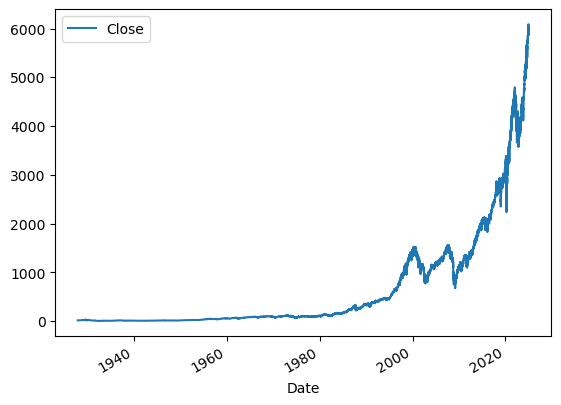

In [5]:
df.plot.line(y="Close", use_index=True)

In [6]:
del df["Dividends"]
del df["Stock Splits"]

<AxesSubplot: xlabel='Date'>

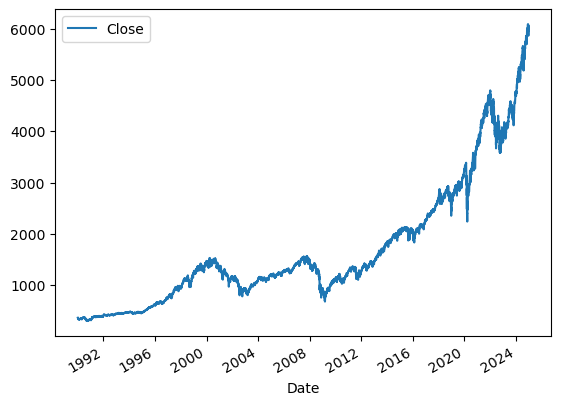

In [7]:
df["Tomorrow"] = df["Close"].shift(-1)
df["Target"] = (df["Tomorrow"] > df["Close"]).astype(int)
df = df.loc["1990-01-01":].copy()
df.plot.line(y="Close", use_index=True)

In [8]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=1000, min_samples_split=100, random_state=1)

train = df.iloc[:-100]
test=df.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, n_estimators=1000, random_state=1)

In [9]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.6571428571428571

<AxesSubplot: xlabel='Date'>

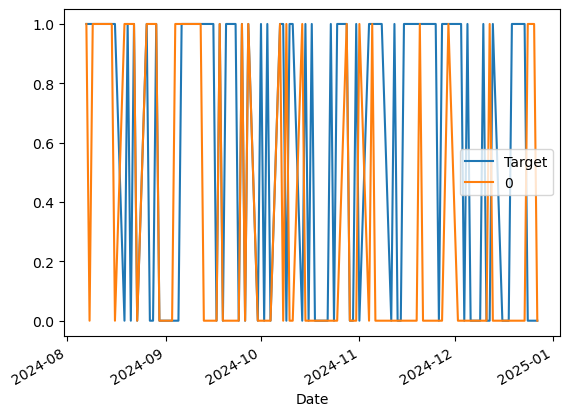

In [10]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [11]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [12]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [13]:
predictions = backtest(df, model, predictors)

In [14]:
predictions["Predictions"].value_counts()

Predictions
0    3659
1    2656
Name: count, dtype: int64

In [15]:
precision_score(predictions["Target"], predictions["Predictions"])

0.53125

In [16]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.536025
0    0.463975
Name: count, dtype: float64

In [17]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = df.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    df[ratio_column] = df["Close"] / rolling_averages["Close"]

    trend_column = f"Trend_{horizon}"
    df[trend_column] = df.shift(1).rolling(horizon).sum()["Target"]

    new_predictors += [ratio_column, trend_column]

In [18]:
df = df.dropna()
df

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1993-12-14 00:00:00-05:00,465.730011,466.119995,462.459991,463.059998,275050000,461.839996,0,0.997157,1.0,0.996617,1.0,1.000283,32.0,1.028047,127.0,1.176082,512.0
1993-12-15 00:00:00-05:00,463.059998,463.690002,461.839996,461.839996,331770000,463.339996,1,0.998681,0.0,0.995899,1.0,0.997329,32.0,1.025151,126.0,1.172676,512.0
1993-12-16 00:00:00-05:00,461.859985,463.980011,461.859985,463.339996,284620000,466.380005,1,1.001621,1.0,0.999495,2.0,1.000311,32.0,1.028274,127.0,1.176163,513.0
1993-12-17 00:00:00-05:00,463.339996,466.380005,463.339996,466.380005,363750000,465.850006,0,1.003270,2.0,1.004991,3.0,1.006561,32.0,1.034781,128.0,1.183537,514.0
1993-12-20 00:00:00-05:00,466.380005,466.899994,465.529999,465.850006,255900000,465.299988,0,0.999431,1.0,1.003784,2.0,1.005120,32.0,1.033359,128.0,1.181856,513.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-19 00:00:00-05:00,5912.709961,5935.520020,5866.069824,5867.080078,4896880000,5930.850098,1,0.999567,0.0,0.980624,1.0,0.995673,34.0,1.086466,144.0,1.300843,530.0
2024-12-20 00:00:00-05:00,5842.000000,5982.060059,5832.299805,5930.850098,8223220000,5974.069824,1,1.005405,1.0,0.995283,2.0,1.005967,34.0,1.097319,144.0,1.314341,530.0
2024-12-23 00:00:00-05:00,5940.250000,5978.250000,5902.569824,5974.069824,3593280000,6040.040039,1,1.003630,2.0,1.005913,2.0,1.012622,35.0,1.104335,144.0,1.323269,530.0


In [19]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [20]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >= .6] = 1
    preds[preds < .6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [21]:
predictions = backtest(df, model, new_predictors)

In [22]:
predictions["Predictions"].value_counts()

Predictions
0.0    4461
1.0     853
Name: count, dtype: int64

In [23]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5720984759671747